In [15]:

# Imports and basic functions

import matplotlib.pyplot as plt
import matplotlib.image as io
import cv2
import numpy as np
from scipy import stats


def show_images(images, titles=None):
    # This function is used to show image(s) with titles by sending an array of images and an array of associated
    # titles. images[0] will be drawn with the title titles[0] if exists You aren't required to understand this
    # function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()
        
def show_hist(hist):
    plt.plot(hist)
    plt.show()


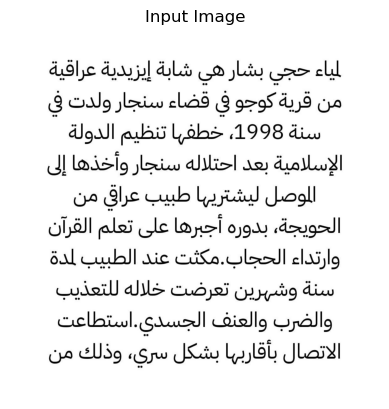

In [16]:
img_path = "train-dataset/IBM Plex Sans Arabic/1.jpeg"
input_image = cv2.imread(img_path)
show_images([input_image] , ["Input Image"])

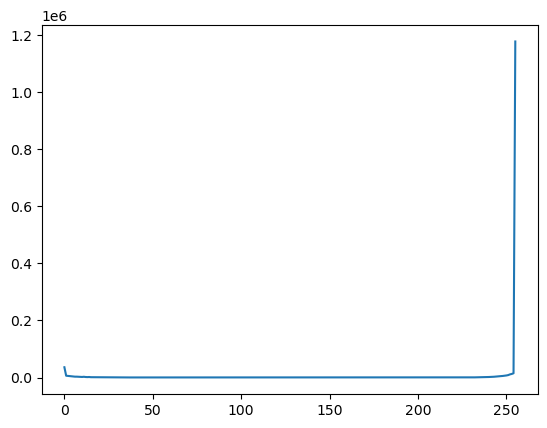

Image Shape:  (1181, 1181)


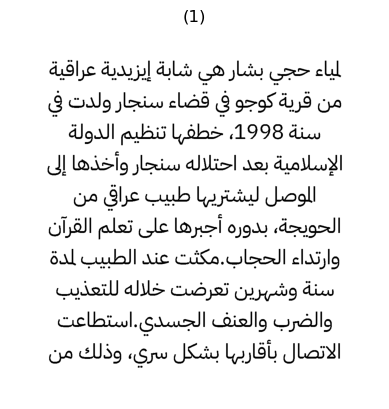

True

In [17]:
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    histogram = cv2.calcHist([gray], [0], None, [256], [0, 256])
    show_hist(histogram)
    max_index = np.argmax(histogram)
    size = gray.shape
    if ((histogram[max_index] - size[0] * size[1]) / (size[0] * size[1])) > 0.95:
        # image is empty
        return gray , True
    thres = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)[1]
    if max_index < 100:
        thres = 1 - thres
    return thres, False
    
seg , empty = preprocess_image(input_image)
if empty:
    print("Empty Image")

print("Image Shape: ", seg.shape)
show_images([seg])

cv2.imwrite("temp/seg.png" , seg)

Found: 10 Lines


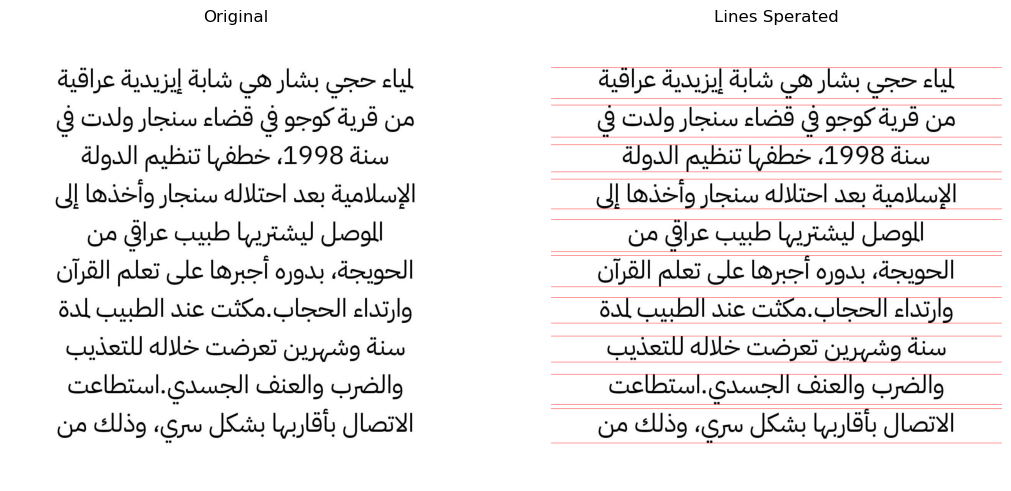

In [18]:

# in this stage we try to calculate where each line is at
# idea:
#   - create a horizental projection of the image
#   - check for peaks
#   - merge close peaks with certain threshold
#   - draw lines for testing ..
def separate_lines(image , MinOfMean = 0.8, temp=None, showHist=False):
    # find the horizental projection
    projection = np.sum(image, axis=1)
    shape = image.shape
    
    if showHist:
        show_hist(projection)

    flag = 0
    start = -1
    lines = []
    line_widths = []
    for i in range(len(projection)):
        if projection[i] != (shape[1]) and flag == 0: # start
            start = i - 1
            flag = 1
        if projection[i] == (shape[1]) and flag == 1: #end
            lines.append([start, i])
            line_widths.append(i - start)
            flag = 0

    mean_value = np.mean(line_widths)
    min_value = mean_value * MinOfMean

    i = 0
    while i < len(lines):
        if line_widths[i] < min_value:
            
            if i != 0:
                # try to merge it with the line before it ..
                l = lines.pop(i)
                w = line_widths.pop(i)
                lines[i - 1][1] = l[1]
                line_widths[i - 1] = lines[i - 1][1] - lines[i - 1][0]
                i = i - 1
            elif i != len(lines) - 1:
                # try to merge it with the line after it ..
                l = lines.pop(i)
                w = line_widths.pop(i)
                lines[i][1] = l[1]
                line_widths[i] = lines[i][1] - lines[i][0]
                i = i - 1
            else:
                # can't merge it ..
                l = lines.pop(i)
                w = line_widths.pop(i)
                i = i - 1
            
        i = i + 1

    print("Found: %d Lines" % len(lines))

    if temp is not None:
        for i in range(len(lines)):
            cv2.line(temp , (0 , lines[i][0]) , (shape[1],lines[i][0]) , (255,0,0), 1)
            cv2.line(temp , (0 , lines[i][1]) , (shape[1],lines[i][1]) , (255,0,0), 1)
    return lines


lines_image = np.copy(input_image)
lines = separate_lines(seg // 255 , temp=lines_image)
show_images([input_image , lines_image] , ["Original" , "Lines Sperated"])

Found: 8 Gaps
Found: 7 Words
Found: 8 Gaps
Found: 7 Words
Found: 6 Gaps
Found: 5 Words
Found: 7 Gaps
Found: 6 Words
Found: 6 Gaps
Found: 5 Words
Found: 7 Gaps
Found: 6 Words
Found: 6 Gaps
Found: 5 Words
Found: 6 Gaps
Found: 5 Words
Found: 4 Gaps
Found: 3 Words
Found: 7 Gaps
Found: 6 Words


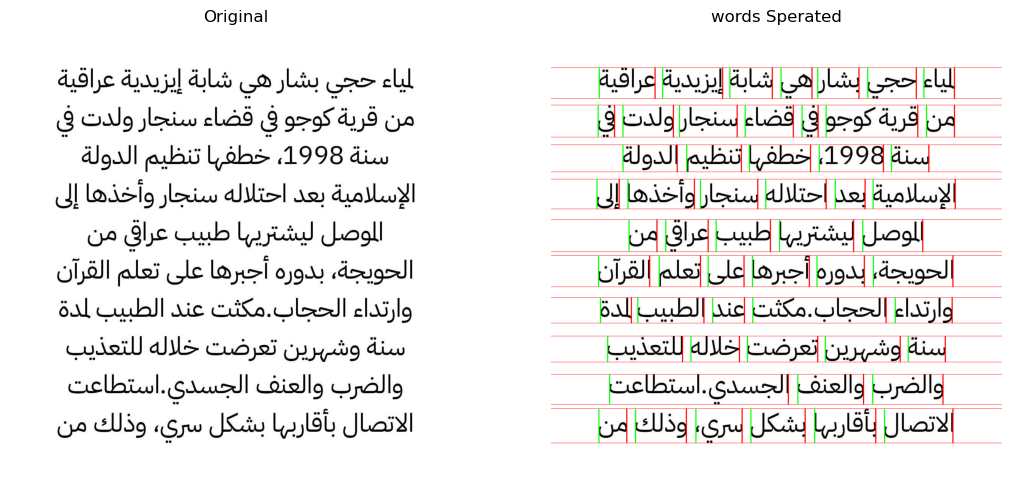

In [19]:
# now we need to separate words itself from each other
# to do this we will take similar approch but on the vertical axis

def separate_words(image, line , MinOfMean = 0.8, temp=None, showHist=False):
    # find the horizental projection
    projection = np.sum(image[line[0]:line[1] , :], axis=0)
    shape = image.shape
    if showHist:
        show_hist(projection)

    flag = 0
    start = 0
    lines = []
    line_widths = []
    for i in range(len(projection)):
        if projection[i] == (line[1] - line[0]) and flag == 0: # start
            start = i - 1
            flag = 1
        if (projection[i] != (line[1] - line[0]) and flag == 1) or (i == len(projection) - 1): #end
            lines.append([start, i])
            line_widths.append(i - start)
            flag = 0

    mean_value = np.mean(line_widths[1:-1])
    min_value = mean_value * MinOfMean

    # remove small gaps (aka: gaps inside the same word)
    i = 0
    while i < len(lines):
        if line_widths[i] < min_value:
            l = lines.pop(i)
            w = line_widths.pop(i)
            i = i - 1
        i = i + 1
    print("Found: %d Gaps" % len(lines))

    # now that we have the gaps, we can calculate words positions
    words = []
    for i in range(len(lines)):
        if i != len(lines) - 1:
            words.append([lines[i][1] , lines[i + 1][0]])

    print("Found: %d Words" % len(words))

    if temp is not None:
        for i in range(len(words)):
            cv2.line(temp , (words[i][0] , line[0]) , (words[i][0] ,line[1]) , (0,255,0), 2)
            cv2.line(temp , (words[i][1] , line[0]) , (words[i][1] ,line[1]) , (255,0,0), 2)

    return words , lines



words_image = np.copy(lines_image)
words = []
for line in lines:
    words.append(separate_words(seg // 255 , line , 1 , words_image)[0])
    
show_images([input_image , words_image] , ["Original" , "words Sperated"])


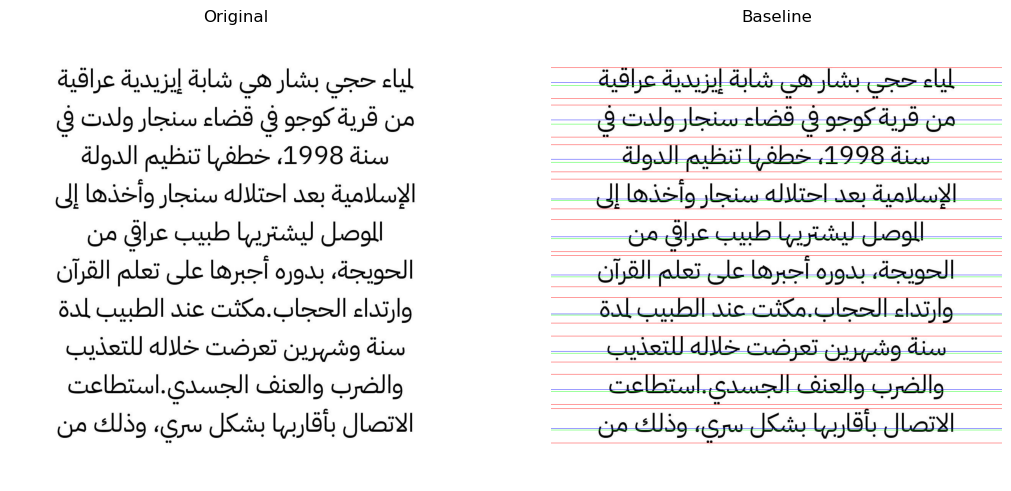

In [53]:
# now that we have the words in each line, what we need to do next is to
# calculate the baseline of the each line as well as the line that achieves
# the most intersections above the base line, sinece it will help use find
# each character region
def find_baseline(image, line, temp=None , showHist=True):
    projection = np.sum(image[line[0]:line[1] , :], axis=1)
    shape = image.shape
    if showHist:
        show_hist(projection)

    kernel = np.ones(3) / 3
    smoothed = np.convolve(projection , kernel, mode='same')
    if showHist:
        show_hist(smoothed)


    baseline = line[1] - line[0] - 1
    min_value = smoothed[len(smoothed) - 1]
    for i in range(len(smoothed) - 2, -1 , -1):
        if (smoothed[i] < min_value):
            baseline = i
            min_value = smoothed[i]

    i = baseline - 1
    maxTransitionsIndex = -1
    maxTransitions = 0

    while i >= 0:
        # calculate the transitions
        t = 0
        f = 0
        for k in range(shape[1]):
            if image[i + line[0] , k] == 0 and f == 0:
                f = 1
            if image[i + line[0] , k] != 0 and f == 1:
                f = 0
                t += 1
        if t >= maxTransitions:
            maxTransitions = t
            maxTransitionsIndex = i
        i = i - 1
    # now we need to calculate the 
    if temp is not None:
        cv2.line(temp , (0 , baseline + line[0]) , (shape[1], baseline + line[0]) , (0,255,0), 1)
        cv2.line(temp , (0 , maxTransitionsIndex + line[0]) , (shape[1], maxTransitionsIndex + line[0]) , (0,0,255), 1)

    return baseline , maxTransitionsIndex
            

baseline_image = np.copy(lines_image)
baselines = []
for line in lines:
    baselines.append(find_baseline(seg // 255 , line , temp=baseline_image, showHist=False))

show_images([input_image , baseline_image] , ["Original" , "Baseline"])

Baseline width: 61
SRs: 5
SRs: 8
SRs: 4
SRs: 13
SRs: 10
CASE Abdo - 2 (pure hbd)
CASE Abdo - 2 (pure hbd)
CASE Abdo - 2 (pure hbd)
CASE 1
CASE 3
CASE 1
CASE 1
CASE 7
 CASE 7.2
CASE 3
CASE Abdo - 2 (pure hbd)
CASE Abdo - 2 (pure hbd)
CASE Abdo - 2 (pure hbd)
CASE Abdo - 2 (pure hbd)
CASE Abdo - 2 (pure hbd)
CASE Abdo - 2 (pure hbd)
CASE Abdo - 2 (pure hbd)
CASE Abdo - 2 (pure hbd)
CASE 1
CASE 1
CASE 7
 CASE 7.2
CASE 7
 CASE 7.2
CASE Abdo - 2 (pure hbd)
CASE 1
CASE Abdo - 2 (pure hbd)
CASE 1
CASE 1
CASE 7
 CASE 7.2
CASE 7
 CASE 7.2
CASE Abdo - 2 (pure hbd)
CASE Abdo - 2 (pure hbd)
CASE 3
CASE 3
CASE 1
CASE 1
CASE 4
 CASE 4.1
CASE Abdo - 2 (pure hbd)
CASE Abdo - 2 (pure hbd)
CASE 1
CASE 1
CASE Abdo - 2 (pure hbd)


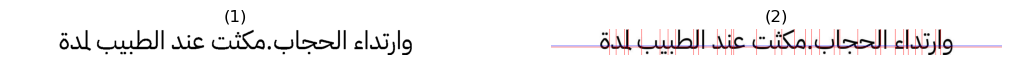

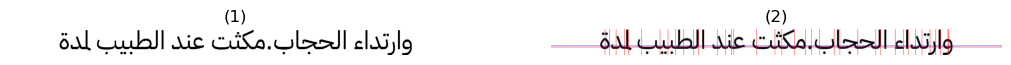

[[(202, 209, 202), (187, 197, 192), (163, 178, 170), (152, 158, 153)],
 [(385, 399, 386),
  (385, 396, 386),
  (368, 378, 373),
  (321, 331, 326),
  (300, 312, 306),
  (280, 291, 285),
  (237, 269, 237)],
 [(472, 505, 472), (472, 485, 478), (452, 463, 457), (428, 443, 435)],
 [(862, 876, 863),
  (862, 873, 863),
  (844, 856, 850),
  (800, 818, 803),
  (756, 774, 756),
  (740, 749, 741),
  (703, 732, 703),
  (681, 692, 682),
  (666, 675, 666),
  (632, 640, 637),
  (601, 618, 604),
  (581, 592, 586),
  (538, 571, 538)],
 [(1020, 1028, 1020),
  (1007, 1015, 1007),
  (971, 981, 971),
  (947, 962, 954),
  (935, 942, 935),
  (910, 930, 923),
  (901, 904, 901)]]

In [75]:
# now to generate the separation regions ..
from collections import Counter
def isThereHole(sr_img, cut_index_line):  ##########
    found = False
    for i in range(1,len(cut_index_line)):
        if(cut_index_line[i] != cut_index_line[i - 1] and cut_index_line[i] == 1):
            found = True
        elif(cut_index_line[i] != cut_index_line[i - 1] and cut_index_line[i] == 0 and found):
            return True
    return False

def calcRegionHeight(VP_end,baseline):
    for i in range(0, baseline):
        if (VP_end[i] == 0):
            return baseline - i
    return 0

def isStroke( HP, baseline, SHPA, SHPB, VP_start, MFV):
    condition_2 = SHPA <= SHPB
    condition_3 = calcRegionHeight(VP_start,baseline) >= (2 * sorted(HP)[1]) ########
    condition_4 = stats.mode(HP).mode == MFV
    return condition_2 and condition_3 and condition_4 

def hasDots(sr_img,baseline):
    upper_half = sr_img[0:baseline,:]
    lower_half = sr_img[baseline:,:]
    upper_comp = cv2.connectedComponents(upper_half)
    lower_comp = cv2.connectedComponents(lower_half)
    return (lower_comp[0] + upper_comp[0]) > 2
    


    
def find_cut_points(image , line , words , maxTransitionsLine , baseline , temp=None , show=True):
    line_img = image[line[0]:line[1] , :]
    kernal = kernel = np.ones((2, 2), np.uint8)
    opened_img = cv2.morphologyEx(line_img, cv2.MORPH_OPEN, kernel)
    
    VP = np.sum(line_img, axis=0)
    #if show:
    #    show_hist(VP)

    vertical_projection = np.sum(line_img[:, words[0][0]:words[-1][1]], axis=0)
    mods                = Counter(vertical_projection)
    baselines_width     = mods.most_common(1)[0][0]
    line_height         = line[1] - line[0]
    print(f"Baseline width: {baselines_width}")

    totalSRs = []
    for word in words:
        i = 0
        f = 0
        end_index = -1
        SRs = []
        for i in range(word[0] , word[1]):
            sr = None
            if line_img[maxTransitionsLine + 1 , i] != 0 and f == 0: # unlike paper, words are letters are colored black !! 
                f = 1
                end_index = i
            elif (line_img[maxTransitionsLine + 1, i] == 0 and f == 1) or i == word[1] - 1:
                start_index = i
                mid = (start_index + end_index) // 2
                f = 0
                
                if (start_index - end_index) / (word[1] - word[0]) < 0.02:
                    continue
                
                for k in range(end_index, start_index):
                    if (VP[k] == line_height):
                        sr = (end_index , start_index , k)
                        break
                if sr != None:
                    SRs.append(sr)
                    continue

                if VP[mid] == baselines_width:
                    sr = (end_index , start_index , mid)
                    SRs.append(sr)
                    continue

                for k in range(end_index, start_index):
                    if (VP[k] >= baselines_width):
                        sr = (end_index , start_index , k)
                        break
                
                if sr != None:
                    SRs.append(sr)
                    continue

                sr = (end_index , start_index , mid)
                SRs.append(sr)

        print(f"SRs: {len(SRs)}")    
        totalSRs.append(SRs)


    SRs_image = np.copy(input_image[line[0]:line[1], :])
    
    totalValidSRs = []
    for k in totalSRs:
        validSRs = []
        skip_count = 0
        for it in range(len(k) - 1, -1 , -1):

            if(skip_count > 0):
                skip_count = skip_count - 1
                continue

            j = k[it]

            if(it >= 1):
                next = k[it - 1]

            if(it >= 2):
                n_next = k[it - 2] 

            end   = j[0]
            start = j[1]
            div   = j[2] # div is the cut point
            
            if(next):
                end_next   = next[0]
                start_next = next[1]
                div_next   = next[2]

            if(n_next):
                end_n_next = n_next[0]
                start_n_next = n_next[1]
                div_n_next = n_next[2]

            sr_img        = line_img[:,end:start]
            sr_next_img   = line_img[:,end_next:start_next]
            sr_n_next_img = line_img[:,end_n_next:start_n_next]

            HP        = np.sum(sr_img, axis= 1)
            HP_next   = np.sum(sr_next_img, axis= 1)
            HP_n_next = np.sum(sr_n_next_img, axis= 1)

            SHPB        = np.sum(HP[baseline: line_height]) # horizontal projection below baseline
            SHPA        = np.sum(HP[0: baseline])           # horizontal projection above baseline
            SHPB_next   = np.sum(HP_next[baseline: line_height]) 
            SHPA_next   = np.sum(HP_next[0: baseline]) 
            SHPB_n_next = np.sum(HP_n_next[baseline: line_height]) 
            SHPA_n_next = np.sum(HP_n_next[0: baseline]) 

            VP_end        = line_img[0:baseline, end       ] 
            VP_start      = line_img[0:baseline, start     ] 
            VP_next_end   = line_img[0:baseline, end_next  ]
            VP_n_next_end = line_img[0:baseline, end_n_next]

            cut_index_line = line_img[:,div]

            is_stroke = isStroke(HP,baseline,SHPA,SHPB,VP_start,baselines_width)
            if(next):
                is_next_stroke = isStroke(HP_next,baseline,SHPA_next,SHPB_next,VP_next_end,baselines_width)
            if(n_next):
                is_n_next_stroke = isStroke(HP_n_next,baseline,SHPA_n_next,SHPB_n_next,VP_n_next_end,baselines_width)
            if VP[div] == line_height: # case 1 : speration is not inside a character
                validSRs.append(j)
                print("CASE 1")
            elif np.min(HP) != 0: # case 2 : no connected path between start and end
                validSRs.append(j)
                print("CASE 2")
            elif isThereHole(sr_img, cut_index_line): # case 3 : there is a hole in the character
                print("CASE 3")
                continue
            elif abs(VP[div] - baselines_width) < 2 and (it >= 1) and VP[div_next] == line_height:
                validSRs.append(j)
                print("CASE Abdo - 1 (pure hbd)")
            elif abs(VP[div] - baselines_width) < 2 and np.sum(sr_img[0:baseline - 1,:] , axis=0)[0] > line_height / 1.6:
                validSRs.append(j)
                print("CASE Abdo - 2 (pure hbd)")
            elif HP[baseline] != 0: # case 4 : there is no baseline between start and end
                print("CASE 4")
                if SHPB <= SHPA: 
                    print(" CASE 4.1")
                    continue
                elif VP[div] >= baselines_width:
                    validSRs.append(j)
                    print(" CASE 4.2")
                else:
                    print(" CASE 4.3")
                    continue
            elif (it == 0): # case 5 : it is the last region
                print("CASE 5")
                break
            elif (VP[div_next] == line_height) and (calcRegionHeight(VP_end,baseline) < (baseline / 2)):
                print("CASE 6")                                                                # case 6 : if the vertical projection at the cut index of 
                if SHPA <= SHPB and abs(VP[div] - baselines_width) < 2:                        # the next region equals one and the height of the top-left                           
                    validSRs.append(j)                                                         # pixel of the region is less than half the distance 
                    print(" CASE 6.1")                                                         # between baseline and the top pixel of the line
                else:                             
                    print(" CASE 6.2")                                              
                    continue
            elif not is_stroke:   # case 7 : if sr is not a stroke
                print("CASE 7")
                if HP_next[baseline] != 0 and VP[div_next] > baselines_width:  # no baseline between start and end index of next region and
                    print(" CASE 7.1")                                         # cut index of next region is greater than MFV
                    continue                                                   
                else:
                    validSRs.append(j)
                    print(" CASE 7.2")                             
            elif is_stroke and hasDots(sr_img,baseline):  # case 8 : if sr is stroke with dots above or below
                print("CASE 8")
                show_images([sr_img]) 
                validSRs.append(j)
            elif is_stroke and not hasDots(sr_img,baseline):  # case 9 : if sr is stroke without dots
                print("CASE 9")
                if is_next_stroke and not hasDots(sr_next_img,baseline):  # if the next sr is stroke without dots
                    print(" CASE 9.1")
                    validSRs.append(j)
                    skip_count = 2
                if is_next_stroke and hasDots(sr_next_img,baseline) and is_n_next_stroke and not hasDots(sr_n_next_img,baseline): 
                    print(" CASE 9.2")          # if the next sr is stroke with dots and the next next sr is stroke without dots
                    validSRs.append(j)
                    skip_count = 2
                if not is_next_stroke or (is_next_stroke and hasDots(sr_next_img,baseline)):  # if the next sr is not stroke or stroke with dots
                    print(" CASE 9.3")
                    continue

        totalValidSRs.append(validSRs)
            

    for k in totalValidSRs: # debug draw ..
        for j in k:
            cv2.line(SRs_image , (j[2] , 0) , (j[2] , line_height) , (255 , 0 , 0) , 1)

    if show:
        cv2.line(SRs_image , (0 , maxTransitionsLine) , (SRs_image.shape[1], maxTransitionsLine) , (0,0,255), 1)
        cv2.line(SRs_image , (0 , baseline) , (SRs_image.shape[1], baseline) , (255,0,0), 1)
        show_images([opened_img , SRs_image])

    for k in totalSRs: # debug draw ..
        for j in k:
            cv2.line(SRs_image , (j[2] , 0) , (j[2] , line_height) , (255 , 0 , 0) , 1)
            #cv2.line(SRs_image , (j[0] , 0) , (j[0] , line_height) , (0 , 255 , 0) , 1)
            #cv2.line(SRs_image , (j[1] , 0) , (j[1] , line_height) , (0 , 0 , 255) , 1)

    if show:
        cv2.line(SRs_image , (0 , maxTransitionsLine) , (SRs_image.shape[1], maxTransitionsLine) , (0,0,255), 1)
        show_images([opened_img , SRs_image])


    return totalValidSRs
    

                
target = 6
find_cut_points(seg // 255 , lines[target] , words[target] , baselines[target][1], baselines[target][0])